In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Functions

In [2]:
def initialize_parameters(layer_dims):
    """
    Initializes parameters W and b for each layer.
    W: random normal scaled by sqrt of previous layer size
    b: zeros
    """
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)  # number of layers

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2. / layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    return parameters

def linear_forward(A, W, b):
    """
    Computes the linear part of a layer's forward propagation.
    """
    Z = np.dot(W, A) + b
    linear_cache = (A, W, b)
    return Z, linear_cache

def softmax(Z):
    """
    Computes softmax activation.
    """
    Z_shift = Z - np.max(Z, axis=0, keepdims=True)
    expZ = np.exp(Z_shift)
    A = expZ / np.sum(expZ, axis=0, keepdims=True)
    activation_cache = Z
    return A, activation_cache

def relu(Z):
    """
    Computes ReLU activation.
    """
    A = np.maximum(0, Z)
    activation_cache = Z
    return A, activation_cache

def linear_activation_forward(A_prev, W, b, activation):
    """
    Forward propagation for LINEAR->ACTIVATION layer.
    """
    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "softmax":
        A, activation_cache = softmax(Z)
    cache = (linear_cache, activation_cache)
    return A, cache

def apply_batchnorm(A):
    """
    Applies batch normalization to activation values.
    """
    mu = np.mean(A, axis=1, keepdims=True)
    var = np.var(A, axis=1, keepdims=True)
    NA = (A - mu) / np.sqrt(var + 1e-8)
    return NA

def l_model_forward(X, parameters, use_batchnorm):
    """
    Forward propagation for [LINEAR->RELU]*(L-1)->LINEAR->SOFTMAX.
    """
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W'+str(l)], parameters['b'+str(l)], "relu")
        if use_batchnorm:
            A = apply_batchnorm(A)
        caches.append(cache)
    # Final layer
    AL, cache = linear_activation_forward(A, parameters['W'+str(L)], parameters['b'+str(L)], "softmax")
    caches.append(cache)
    return AL, caches

def compute_cost(AL, Y):
    """
    Computes categorical cross-entropy loss.
    """
    m = Y.shape[1]
    cost = -np.sum(Y * np.log(AL + 1e-8)) / m
    return cost

def linear_backward(dZ, cache):
    """
    Linear part of backward propagation for a single layer.
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db

def relu_backward(dA, activation_cache):
    """
    Backward propagation for a ReLU unit.
    """
    Z = activation_cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

def softmax_backward(dA, activation_cache):
    """
    Backward propagation for a softmax unit.
    """
    # dA is AL - Y as per instructions
    dZ = dA
    return dZ

def linear_activation_backward(dA, cache, activation):
    """
    Backward propagation for LINEAR->ACTIVATION layer.
    """
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

def l_model_backward(AL, Y, caches):
    """
    Backward propagation for the entire network.
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]

    # Output layer (softmax)
    dAL = AL - Y  # as per instructions
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "softmax")

    # Hidden layers (ReLU)
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev, dW, db = linear_activation_backward(grads["dA" + str(l+2)], current_cache, "relu")
        grads["dA" + str(l+1)] = dA_prev
        grads["dW" + str(l+1)] = dW
        grads["db" + str(l+1)] = db
    return grads

def update_parameters(parameters, grads, learning_rate):
    """
    Updates parameters using gradient descent.
    """
    L = len(parameters) // 2
    for l in range(1, L+1):
        parameters['W'+str(l)] -= learning_rate * grads['dW'+str(l)]
        parameters['b'+str(l)] -= learning_rate * grads['db'+str(l)]
    return parameters

def l_layer_model(X, Y, layers_dims, learning_rate, num_iterations, batch_size, use_batchnorm):
    """
    Implements a L-layer neural network.
    """
    np.random.seed(1)
    costs = []
    parameters = initialize_parameters(layers_dims)
    m = X.shape[1]

    for i in range(num_iterations):
        # Mini-batch
        permutation = np.random.permutation(m)
        X_shuffled = X[:, permutation]
        Y_shuffled = Y[:, permutation]

        for k in range(0, m, batch_size):
            X_batch = X_shuffled[:, k:k+batch_size]
            Y_batch = Y_shuffled[:, k:k+batch_size]

            AL, caches = l_model_forward(X_batch, parameters, use_batchnorm)
            cost = compute_cost(AL, Y_batch)
            grads = l_model_backward(AL, Y_batch, caches)
            parameters = update_parameters(parameters, grads, learning_rate)

        if i % 100 == 0:
            costs.append(cost)

    return parameters, costs

def predict(X, Y, parameters, use_batchnorm):
    """
    Predicts and computes accuracy.
    """
    AL, _ = l_model_forward(X, parameters, use_batchnorm)
    predictions = np.argmax(AL, axis=0)
    labels = np.argmax(Y, axis=0)
    accuracy = np.mean(predictions == labels)
    return accuracy

def early_stopping(val_acc_history, patience=5, min_delta=0):
    """
    Checks for early stopping based on validation accuracy.

    Args:
        val_acc_history (list): List of validation accuracies.
        patience (int): Number of epochs to wait after last time validation accuracy improved.
        min_delta (float): Minimum change in the validation accuracy to qualify as an improvement.

    Returns:
        bool: True if training should stop, False otherwise.
    """
    if len(val_acc_history) < patience:
      return False

    recent_accuracies = val_acc_history[-patience:]
    best_accuracy = max(recent_accuracies)
    best_accuracy_index = recent_accuracies.index(best_accuracy)

    # Stop if there's been no significant improvement
    if best_accuracy_index != patience - 1 and best_accuracy - min_delta > recent_accuracies[-1]:
      return True

    return False


## Data Load

In [3]:
# Load MNIST data
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

# Flatten and normalize
X_train_full = X_train_full.reshape(-1, 784).T / 255.0
X_test = X_test.reshape(-1, 784).T / 255.0

# One-hot encode labels
def one_hot(y, classes=10):
    return np.eye(classes)[y].T  # transpose directly here

Y_train_full = one_hot(y_train_full)
Y_test = one_hot(y_test)  # now already has shape (10, num_samples)

# Split validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train_full.T, Y_train_full.T,
                                                test_size=0.2, stratify=y_train_full,
                                                random_state=1)
X_train, X_val, Y_train, Y_val = X_train.T, X_val.T, Y_train.T, Y_val.T

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Training function

In [4]:
def train_model(X_train, Y_train, X_val, Y_val, layers_dims, learning_rate, batch_size, use_batchnorm):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    iterations = 0
    epoch_counter = 0
    samples_count = X_train.shape[1]

    parameters = initialize_parameters(layers_dims)

    print(f"{'Epoch':<8} {'Iterations':<12} {'Train Acc':<12} {'Val Acc':<12} {'Train Loss':<12} {'Val Loss':<12}")
    print("-" * 80)

    while True:
        # Mini-batch training
        num_batches = batch_size

        for k in range(num_batches):
          X_batch = X_train[:, k * batch_size: (k + 1) * batch_size]
          Y_batch = Y_train[:, k * batch_size: (k + 1) * batch_size]

          # Forward pass
          AL_batch, caches = l_model_forward(X_batch, parameters, use_batchnorm)

          # Compute cost
          cost_batch = compute_cost(AL_batch, Y_batch)

          # Backward pass
          grads = l_model_backward(AL_batch, Y_batch, caches)

          # Update parameters
          parameters = update_parameters(parameters, grads, learning_rate)

        # Calculate metrics after each epoch
        AL_train, _ = l_model_forward(X_train, parameters, use_batchnorm)
        train_acc = predict(X_train, Y_train, parameters, use_batchnorm)
        train_loss = compute_cost(AL_train, Y_train)

        AL_val, _ = l_model_forward(X_val, parameters, use_batchnorm)
        val_acc = predict(X_val, Y_val, parameters, use_batchnorm)
        val_loss = compute_cost(AL_val, Y_val)

        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)

        # Update tracking
        iterations += num_batches
        epoch_counter += 1 # Each full pass is an epoch

        print(f"{epoch_counter:8.1f} {iterations:<12} {train_acc:<12.4f} {val_acc:<12.4f} {train_loss:<12.4f} {val_loss:<12.4f}")

        # Check stopping condition
        if early_stopping(val_acc_history):
          break

    # Plotting
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_acc_history, label='Train')
    plt.plot(val_acc_history, label='Validation')
    plt.title('Accuracy vs Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_loss_history, label='Train')
    plt.plot(val_loss_history, label='Validation')
    plt.title('Loss vs Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return parameters

In [5]:
def summarize_weights(parameters, name="Model"):
    print(f"Weight Summary for {name}")
    print("-" * 40)
    for key in parameters:
        if key.startswith("W"):
            W = parameters[key]
            print(f"{key}: shape={W.shape}, mean={np.mean(W):.4f}, std={np.std(W):.4f}, max={np.max(W):.4f}, min={np.min(W):.4f}")


##  MNIST classification (baseline, no batchnorm)

Epoch    Iterations   Train Acc    Val Acc      Train Loss   Val Loss    
--------------------------------------------------------------------------------
     1.0 128          0.2364       0.2387       2.2259       2.2264      
     2.0 256          0.3095       0.3094       2.1103       2.1098      
     3.0 384          0.3491       0.3525       1.9832       1.9817      
     4.0 512          0.3673       0.3743       1.8687       1.8667      
     5.0 640          0.3824       0.3852       1.7645       1.7627      
     6.0 768          0.3934       0.3957       1.6655       1.6641      
     7.0 896          0.4155       0.4150       1.5721       1.5707      
     8.0 1024         0.4467       0.4485       1.4835       1.4817      
     9.0 1152         0.4682       0.4716       1.3967       1.3950      
    10.0 1280         0.4981       0.5009       1.3122       1.3112      
    11.0 1408         0.5314       0.5325       1.2356       1.2346      
    12.0 1536         0.5606   

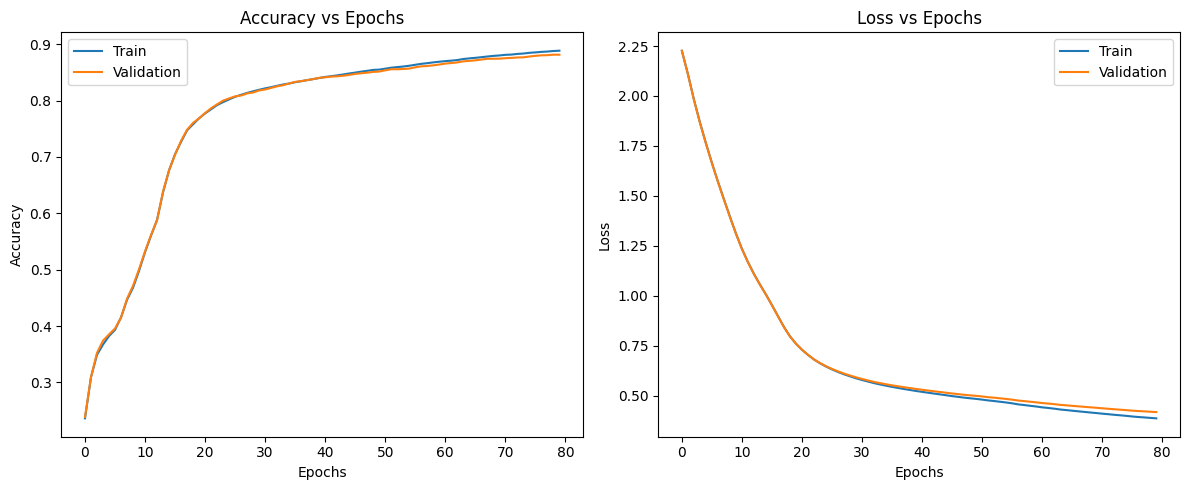

In [6]:
layers_dims = [784, 20, 7, 5, 10]
final_params = train_model(X_train, Y_train, X_val, Y_val, layers_dims,
                          learning_rate=0.009, batch_size=128, use_batchnorm=False)


In [7]:
# === Evaluate on Test Set ===
AL_test, _ = l_model_forward(X_test, final_params, use_batchnorm=False)
test_accuracy = np.mean(np.argmax(AL_test, axis=0) == np.argmax(Y_test, axis=0)) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 87.97%


In [8]:
summarize_weights(final_params, name="Without L2")

Weight Summary for Without L2
----------------------------------------
W1: shape=(20, 784), mean=0.0017, std=0.0604, max=0.3481, min=-0.3064
W2: shape=(7, 20), mean=0.0401, std=0.4702, max=1.2926, min=-1.1635
W3: shape=(5, 7), mean=0.0508, std=0.8403, max=2.3003, min=-1.6872
W4: shape=(10, 5), mean=-0.0911, std=0.8036, max=1.8039, min=-1.4580


##  MNIST with Batch Normalization

Epoch    Iterations   Train Acc    Val Acc      Train Loss   Val Loss    
--------------------------------------------------------------------------------
     1.0 128          0.2197       0.2298       2.3336       2.3233      
     2.0 256          0.2957       0.3003       2.0361       2.0368      
     3.0 384          0.3398       0.3444       1.8856       1.8870      
     4.0 512          0.3859       0.3900       1.7881       1.7915      
     5.0 640          0.4145       0.4122       1.7182       1.7227      
     6.0 768          0.4323       0.4315       1.6625       1.6676      
     7.0 896          0.4477       0.4462       1.6119       1.6163      
     8.0 1024         0.4631       0.4623       1.5634       1.5674      
     9.0 1152         0.4759       0.4765       1.5167       1.5206      
    10.0 1280         0.4911       0.4940       1.4701       1.4732      
    11.0 1408         0.5231       0.5256       1.4246       1.4276      
    12.0 1536         0.5376   

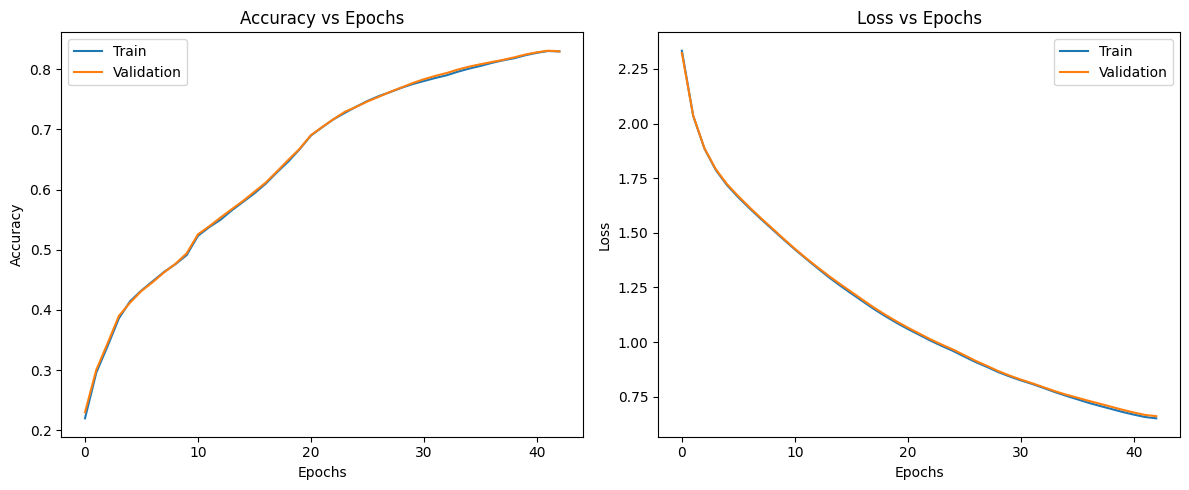

In [9]:
layers_dims = [784, 20, 7, 5, 10]
final_params = train_model(X_train, Y_train, X_val, Y_val, layers_dims,
                          learning_rate=0.009, batch_size=128, use_batchnorm=True)

In [10]:
# === Evaluate on Test Set ===
AL_test, _ = l_model_forward(X_test, final_params, use_batchnorm=True)
test_accuracy = np.mean(np.argmax(AL_test, axis=0) == np.argmax(Y_test, axis=0)) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 83.36%


In [11]:
summarize_weights(final_params, name="Without L2")

Weight Summary for Without L2
----------------------------------------
W1: shape=(20, 784), mean=0.0641, std=0.2621, max=3.5328, min=-1.0583
W2: shape=(7, 20), mean=-0.1251, std=0.9105, max=1.9774, min=-4.1096
W3: shape=(5, 7), mean=-0.1489, std=1.0437, max=2.3341, min=-1.9674
W4: shape=(10, 5), mean=-0.0911, std=0.9084, max=1.8993, min=-1.4732


## L2 Regularization (with and without batchnorm)

In [12]:
def compute_cost(AL, Y, parameters=None, lambd=0):
    """
    Computes cross-entropy cost with optional L2 regularization.

    Arguments:
    AL -- probability matrix from forward prop (shape: [num_classes, m])
    Y -- true labels, one-hot encoded (same shape as AL)
    parameters -- dictionary containing weights W1, W2, ..., WL
    lambd -- regularization hyperparameter (0 means no regularization)

    Returns:
    cost -- scalar value
    """
    m = Y.shape[1]

    # Cross-entropy loss
    cross_entropy_cost = -np.sum(Y * np.log(AL + 1e-8)) / m

    # L2 regularization cost (optional)
    L2_cost = 0
    if parameters is not None and lambd > 0:
        L = len(parameters) // 2  # number of layers
        for l in range(1, L + 1):
            W = parameters[f"W{l}"]
            L2_cost += np.sum(np.square(W))
        L2_cost = (lambd / (2 * m)) * L2_cost

    total_cost = cross_entropy_cost + L2_cost
    return np.squeeze(total_cost)


In [13]:
def l_model_backward(AL, Y, caches, lambd=0, parameters=None):
    """
    Backward propagation for the entire network.
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]

    dAL = AL - Y  # softmax with cross-entropy

    # Output layer
    current_cache = caches[L - 1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(
        dAL, current_cache, activation="softmax", lambd=lambd
    )


    # Hidden layers
    for l in reversed(range(1, L)):
        current_cache = caches[l - 1]
        dA_prev, dW, db = linear_activation_backward(
            grads["dA" + str(l + 1)], current_cache, activation="relu", lambd=lambd
        )
        grads["dA" + str(l)] = dA_prev
        grads["dW" + str(l)] = dW
        grads["db" + str(l)] = db

    return grads


In [14]:
def linear_backward(dZ, cache, W=None, lambd=0):
    """
    Implements the linear portion of backward propagation for a single layer.

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (Z) of the current layer
    cache -- Tuple of values (A_prev, W, b) from forward pass
    W -- Weight matrix of the current layer (needed for L2)
    lambd -- Regularization strength (L2)

    Returns:
    dA_prev -- Gradient w.r.t. the activation from previous layer
    dW -- Gradient w.r.t. W of the current layer
    db -- Gradient w.r.t. b of the current layer
    """
    A_prev, _, _ = cache
    m = A_prev.shape[1]

    dW = (1 / m) * np.dot(dZ, A_prev.T)
    if W is not None and lambd > 0:
        dW += (lambd / m) * W

    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db


In [15]:
def linear_activation_backward(dA, cache, activation, lambd=0):
    """
    Implements the backward propagation for the LINEAR->ACTIVATION layer.
    """
    linear_cache, activation_cache = cache
    A_prev, W, b = linear_cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)
    else:
        raise ValueError("Unsupported activation")

    return linear_backward(dZ, linear_cache, W=W, lambd=lambd)


In [16]:
def train_model(X_train, Y_train, X_val, Y_val, layers_dims, learning_rate, batch_size, use_batchnorm, lambd=0):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    iterations = 0
    epoch_counter = 0
    samples_count = X_train.shape[1]

    parameters = initialize_parameters(layers_dims)

    print(f"{'Epoch':<8} {'Iterations':<12} {'Train Acc':<12} {'Val Acc':<12} {'Train Loss':<12} {'Val Loss':<12}")
    print("-" * 80)

    while True:
        num_batches = batch_size

        for k in range(num_batches):
            X_batch = X_train[:, k * batch_size: (k + 1) * batch_size]
            Y_batch = Y_train[:, k * batch_size: (k + 1) * batch_size]

            # Forward pass
            AL_batch, caches = l_model_forward(X_batch, parameters, use_batchnorm)

            # Compute cost with L2 regularization
            cost_batch = compute_cost(AL_batch, Y_batch, parameters=parameters, lambd=lambd)

            # Backward pass with L2 regularization
            grads = l_model_backward(AL_batch, Y_batch, caches, lambd=lambd)

            # Update parameters
            parameters = update_parameters(parameters, grads, learning_rate)

        # Full train and val pass
        AL_train, _ = l_model_forward(X_train, parameters, use_batchnorm)
        train_acc = predict(X_train, Y_train, parameters, use_batchnorm)
        train_loss = compute_cost(AL_train, Y_train, parameters=parameters, lambd=lambd)

        AL_val, _ = l_model_forward(X_val, parameters, use_batchnorm)
        val_acc = predict(X_val, Y_val, parameters, use_batchnorm)
        val_loss = compute_cost(AL_val, Y_val, parameters=parameters, lambd=lambd)

        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)

        iterations += num_batches
        epoch_counter += 1

        print(f"{epoch_counter:8.1f} {iterations:<12} {train_acc:<12.4f} {val_acc:<12.4f} {train_loss:<12.4f} {val_loss:<12.4f}")

        # Early stopping
        if early_stopping(val_acc_history):
            break

    # Plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_acc_history, label='Train')
    plt.plot(val_acc_history, label='Validation')
    plt.title('Accuracy vs Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_loss_history, label='Train')
    plt.plot(val_loss_history, label='Validation')
    plt.title('Loss vs Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return parameters


Epoch    Iterations   Train Acc    Val Acc      Train Loss   Val Loss    
--------------------------------------------------------------------------------
     1.0 128          0.2368       0.2391       2.2278       2.2301      
     2.0 256          0.3078       0.3076       2.1167       2.1180      
     3.0 384          0.3464       0.3498       1.9948       1.9950      
     4.0 512          0.3641       0.3698       1.8841       1.8838      
     5.0 640          0.3791       0.3823       1.7821       1.7821      
     6.0 768          0.3913       0.3932       1.6845       1.6845      
     7.0 896          0.4139       0.4134       1.5904       1.5903      
     8.0 1024         0.4423       0.4440       1.4998       1.4995      
     9.0 1152         0.4575       0.4597       1.4109       1.4108      
    10.0 1280         0.4884       0.4938       1.3262       1.3266      
    11.0 1408         0.5193       0.5226       1.2524       1.2527      
    12.0 1536         0.5464   

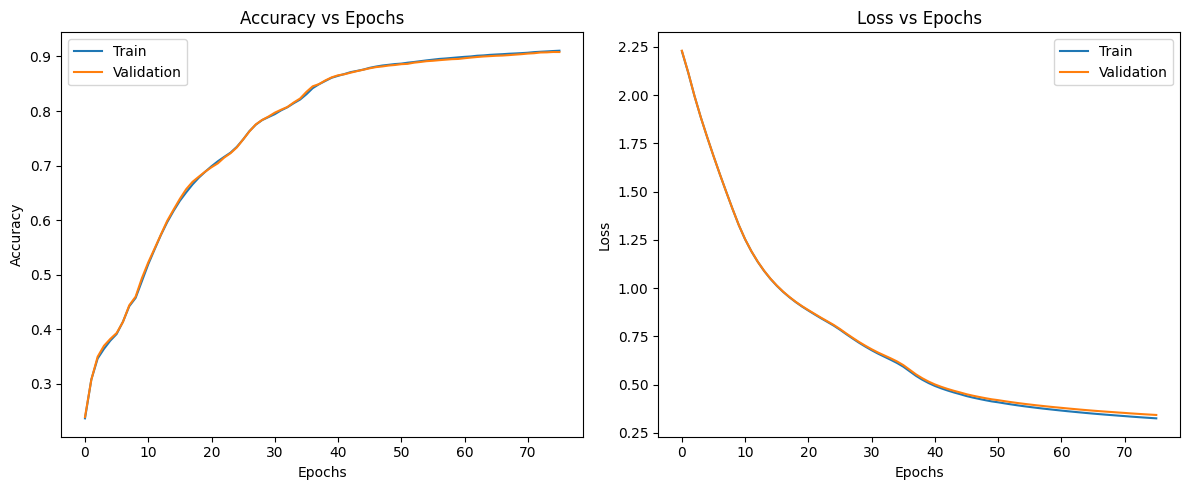

In [18]:
layers_dims = [784, 20, 7, 5, 10]
final_params = train_model(X_train, Y_train, X_val, Y_val, layers_dims,
                          learning_rate=0.009, batch_size=128, use_batchnorm=False, lambd=0.7)

In [19]:
# === Evaluate on Test Set ===
AL_test, _ = l_model_forward(X_test, final_params, use_batchnorm=False)
test_accuracy = np.mean(np.argmax(AL_test, axis=0) == np.argmax(Y_test, axis=0)) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 90.72%


In [21]:
summarize_weights(final_params, name="With L2")

Weight Summary for With L2
----------------------------------------
W1: shape=(20, 784), mean=0.0022, std=0.0437, max=0.2702, min=-0.2788
W2: shape=(7, 20), mean=0.0553, std=0.3728, max=1.1003, min=-0.9053
W3: shape=(5, 7), mean=0.1320, std=0.6933, max=1.9688, min=-1.5687
W4: shape=(10, 5), mean=-0.0564, std=0.6378, max=1.0989, min=-1.2168


Epoch    Iterations   Train Acc    Val Acc      Train Loss   Val Loss    
--------------------------------------------------------------------------------
     1.0 128          0.2177       0.2282       2.3368       2.3277      
     2.0 256          0.2953       0.2999       2.0357       2.0379      
     3.0 384          0.3389       0.3439       1.8868       1.8894      
     4.0 512          0.3846       0.3882       1.7908       1.7954      
     5.0 640          0.4121       0.4113       1.7222       1.7280      
     6.0 768          0.4299       0.4285       1.6677       1.6742      
     7.0 896          0.4448       0.4440       1.6203       1.6259      
     8.0 1024         0.4594       0.4590       1.5742       1.5792      
     9.0 1152         0.4736       0.4722       1.5289       1.5340      
    10.0 1280         0.5070       0.5080       1.4850       1.4893      
    11.0 1408         0.5202       0.5221       1.4409       1.4450      
    12.0 1536         0.5336   

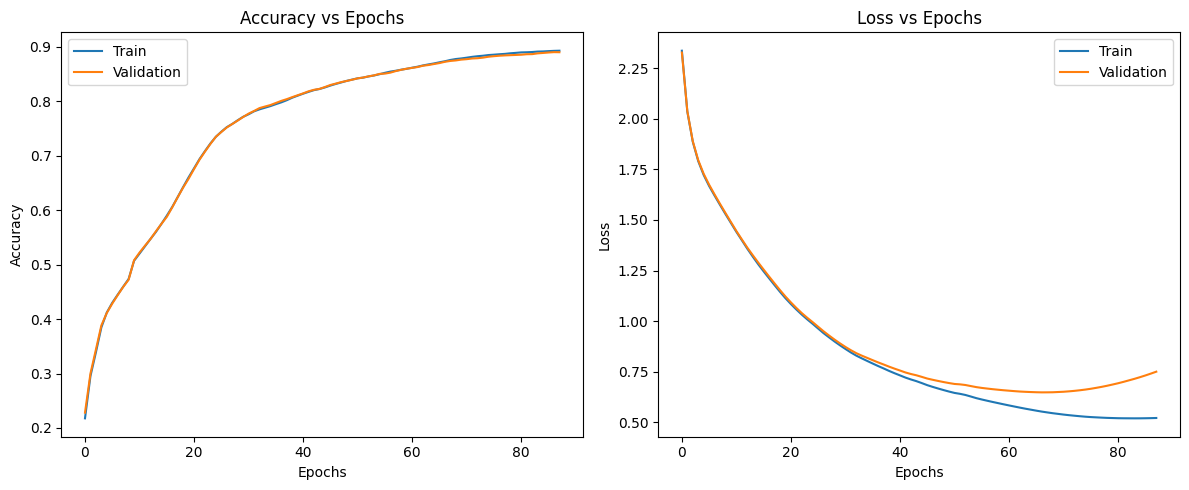

In [22]:
layers_dims = [784, 20, 7, 5, 10]
final_params = train_model(X_train, Y_train, X_val, Y_val, layers_dims,
                          learning_rate=0.009, batch_size=128, use_batchnorm=True, lambd=0.7)

In [25]:
# === Evaluate on Test Set ===
AL_test, _ = l_model_forward(X_test, final_params, use_batchnorm=True)
test_accuracy = np.mean(np.argmax(AL_test, axis=0) == np.argmax(Y_test, axis=0)) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 89.69%


In [26]:
summarize_weights(final_params, name="With L2")

Weight Summary for With L2
----------------------------------------
W1: shape=(20, 784), mean=0.1687, std=0.7426, max=9.0814, min=-3.3695
W2: shape=(7, 20), mean=-0.4314, std=1.9843, max=4.5025, min=-7.0526
W3: shape=(5, 7), mean=-0.2125, std=1.5863, max=3.4108, min=-2.7447
W4: shape=(10, 5), mean=-0.0523, std=0.9855, max=1.8595, min=-1.4782
